# Instrument Beam, Instrument Noise, and Filtering
### Jeff McMahon and Renée Hložek
#### The 2016 CMB Data Analysis Summer School at the University of Michigan

We will now add noise and filter the map - so that we have a map with all astrophysical and instrumental effects.

In [2]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%cd /Users/reneehlozek/Dropbox/ACTSummerSchool  ## put your directory where the maps and libraries live here
%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions
N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

[Errno 2] No such file or directory: '/Users/reneehlozek/Dropbox/ACTSummerSchool ## put your directory where the maps and libraries live here'
/Users/reneehlozek/Code/CMBAnalysis_SummerSchool


## Recalculating the results from the previous stages

('map mean:', -8.7255056904481556, 'map rms:', 99.211788919893266)


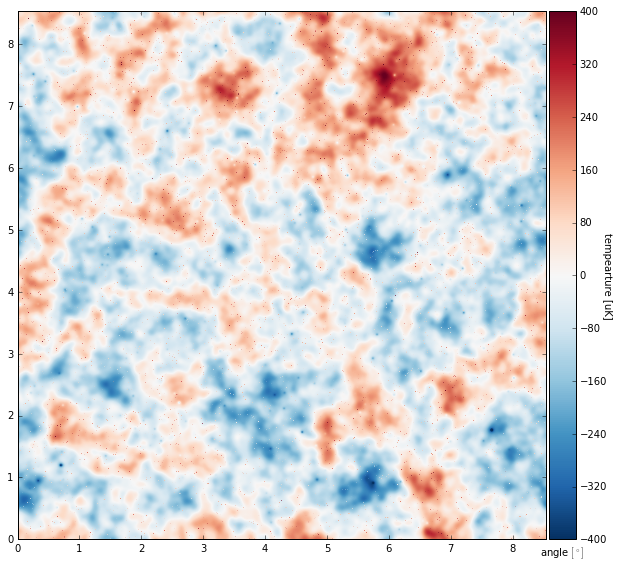

In [3]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,\
                                  Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## plot the result
p=Plot_CMB_Map(total_map,c_min,c_max,X_width,Y_width)

## Sky Map Convolved with a Beam

Telescopes suffer from diffraction which leads to finite resolution effects.  To account for this we generate a Gaussian beam pattern and convolve the map with it.

('map mean:', -8.7255056904481467, 'map rms:', 97.531935297287419)


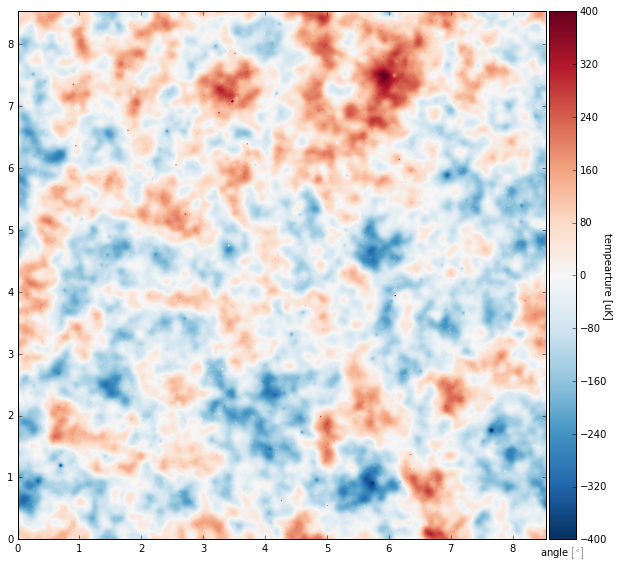

In [5]:
beam_size_fwhp = 1.25

def convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,Map):
    "convolves a map with a Gaussian beam pattern.  NOTE: pix_size and beam_size_fwhp need to be in the same units" 
    # make a 2d gaussian 
    gaussian = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)
  
    # do the convolution
    FT_gaussian = np.fft.fft2(np.fft.fftshift(gaussian))
    FT_Map = np.fft.fft2(np.fft.fftshift(Map))
    convolved_map = np.fft.fftshift(np.real(np.fft.ifft2(FT_gaussian*FT_Map)))
    
    # return the convolved map
    return(convolved_map)
  ###############################   

def make_2d_gaussian_beam(N,pix_size,beam_size_fwhp):
     # make a 2d coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)
  
    # make a 2d gaussian 
    beam_sigma = beam_size_fwhp / np.sqrt(8.*np.log(2))
    gaussian = np.exp(-.5 *(R/beam_sigma)**2.)
    gaussian = gaussian / np.sum(gaussian)
 
    # return the gaussian
    return(gaussian)
  ###############################  
    
    
## convolve the signal part of the map

CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)

p=Plot_CMB_Map(CMB_T_convolved,c_min,c_max,X_width,Y_width)

This plot shows the simulated map that includes the CMB, point source, and SZ signals and is convolved with an instrumental beam.  The agreement with the real sky maps is now reasonable, but does not yet include instrumental noise.

<font color='red'>EXCERCISE: </font>  There are three typical beam sizes for CMB experiments: 1) large anguar scale B-mode observatories which have ~30 arcminute beams; 2) medium scale observatorires such as the Planck sattelite that has a ~3 arcminute beam, and 3) high resolution observatories such as ACT and SPT that have ~1 arcminute beams.  Convolve your map with each of these cases and compare the differences.

In [ ]:
## your code goes here

comment on the differences here

## Noise Map

Ground based CMB instruments suffer from several types of noise.  This includes: (1) White noise drawn from a gaussian distribution; (2) atmospheric noise which grows larger on large angular scales, this can be understood in terms of Kolmogorov turbulence; and (3) $1/f$ noise in the detectors.  Both atmospheric and detector $1/f$ manifest as correlated noise in maps space.  However, like the CMB these noise components are very nearly uncorrelated in Fourier space.  We will build these noise terms in Fourier space and display them in map space. 

We choose a white noise level of 10 $\mu$K-arcmin to approximate the current deep maps coming from ACTPol and SPTPol.  The $1/f$ noise is similar to what would be seen in an experiment at the south pole.  When turned on, this noise leads to the effect of "striping" in the maps.  We default to turning this component off since if it is included we would need to filter the maps before estimating the power spectrum.  (This is easy, but is not yet implemented).  The atmospheric noise (Kolmogorov turbulence) has a 2d spectrum similar to CMB leading to similar patterns in the maps.

/Users/reneehlozek/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/reneehlozek/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('map mean:', 11.284588804612341, 'map rms:', 95.884592432537644)


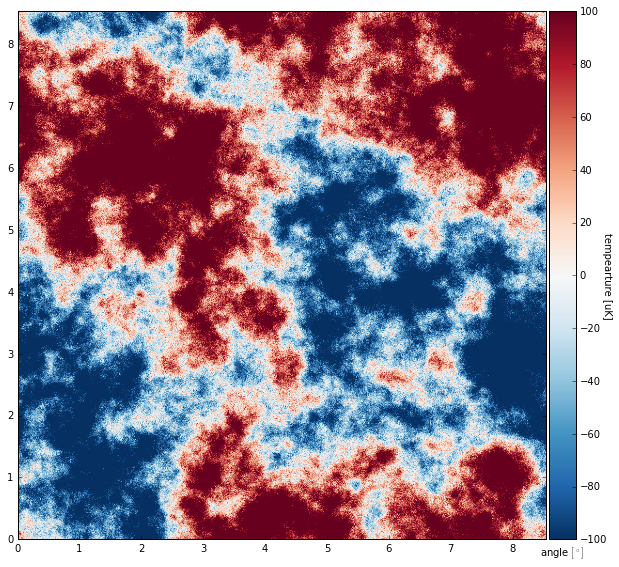

In [21]:
white_noise_level = 10.
atmospheric_noise_level = 0.5*1.  # the multily by zero turns this off
one_over_f_noise_level = 2.0 * 0. # the multily by zero turns this off

def make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level):
    "makes a realization of instrument noise, atmosphere and 1/f noise level set at 1 degrees"
    ## make a white noise map
    white_noise = np.random.normal(0,1,(N,N)) * white_noise_level/pix_size
 
    ## make an atnosperhic noise map
    atmospheric_noise = 0.
    if (atmospheric_noise_level != 0):
        ones = np.ones(N)
        inds  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(ones,inds)
        Y = np.transpose(X)
        R = np.sqrt(X**2. + Y**2.) * pix_size /60. ## angles relative to 1 degrees  
        mag_k = 2 * np.pi/(R+.01)  ## 0.01 is a regularization factor
        atmospheric_noise = np.fft.fft2(np.random.normal(0,1,(N,N)))
        atmospheric_noise  = np.fft.ifft2(atmospheric_noise * np.fft.fftshift(mag_k**(5/3.)))\
        * atmospheric_noise_level/pix_size

    ## make a 1/f map, along a single direction to illustrate striping 
    oneoverf_noise = 0.
    if (one_over_f_noise_level != 0): 
        ones = np.ones(N)
        inds  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(ones,inds) * pix_size /60. ## angles relative to 1 degrees 
        kx = 2 * np.pi/(X+.01) ## 0.01 is a regularization factor
        oneoverf_noise = np.fft.fft2(np.random.normal(0,1,(N,N)))
        oneoverf_noise = np.fft.ifft2(oneoverf_noise * np.fft.fftshift(kx))* one_over_f_noise_level/pix_size

    ## return the noise map
    noise_map = np.real(white_noise + atmospheric_noise + oneoverf_noise)
    return(noise_map)
  ###############################

## make an instrument noise map
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

p=Plot_CMB_Map(Noise,c_min/4.,c_max/4.,X_width,Y_width)

This plot shows a realization of instrumental + atmospheric noise.  The atmospheric noise looks similar to the CMB since it has a similar 2d spectrum.  

<font color='red'>EXCERCISE: </font>  By default the code is run with only a white noise component.  Turn on the atnospheric noise and sepeartely turn on the $1/f$ component.   Comment on how these look.  Plot the absolute value of the 2-d FFT of these maps and note how the non-white component of the noise is localized.   (NOTE this map assumes no cross-linking, the $1/f$ would look different if there were two or more scan direcitons in the map.)

In [ ]:
## your code and plots go here

Your comments go here.

## Filtering

In maps with frequency dependant noise it is often advantageous to filter the maps to 'whiten' the noise spectrum.   There are a wide variety of choices of what to do here.  For both atnospheric and $1/f$ noise, a high pass filter would be an effective choice.  This could either be a square filter (where the modes below some cuttoff are set to zero while shorter wavelenght modes are kept unchanged) or a filter that weights the fourier modes by the $1/A$ where $A$ is the amplitude of the noise distribution.    Below is code that masks out $N_{mask}$ fourier modes along the scan direction.  See the exercise below and play with it.

In [1]:
N_mask =0. ## note this is woefully inadequate 

def Filter_Map(Map,N,N_mask):
    ## set up a x, y, and r coordinates for mask generation
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) 
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)  ## angles realative to 1 degrees  
    
    ## make a mask
    mask  = np.ones([N,N])
    mask[np.where(np.abs(X) < N_mask)]  = 0
    
    ## apply the filter in fourier space
    FMap = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(Map)))
    FMap_filtered = FMap * mask
    Map_filtered = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(FMap_filtered))))
    
    ## return the output
    return(Map_filtered)


filtered = Filter_Map(Noise,N,N_mask)
p=Plot_CMB_Map(filtered,c_min/4.,c_max/4.,X_width,Y_width)

NameError: name 'Noise' is not defined

<font color='red'>EXCERCISE: </font>  Find the minimum $N_{mask}$ that effectively whitens the noise spectrum with the bad $1/f$ turned on.  See how this fitler works for atnospheric noise.  Coment on weather this filter works and whether it is a good choice for atnospheric noise.

In [ ]:
## your code goes here

your notes go here

## Complete Simulated CMB Map

We complete our simulated CMB map by adding the simulated sky map convolved with the beam to our simulated noise map.   

In [ ]:
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)

total_map_plus_noise = CMB_T_convolved + Noise

p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)

This plot shows a complete simulated CMB map including the key astrophysical and instrumental effects.